# Newbie Note

You can just scroll through this document and read it.
If you want to change some of the source code and try it yourself, simply edit the code and press the play button to the left of the code.
If you get errors, be sure you have first run all the previous code in the document. The easiest way to do that is pick "Run All" from the "Runtime" menu.

# Net Present Value

This document shows how to compute the net present value for a product.

Net present value (NPV) is the difference between the present value of cash inflows and the present value of cash outflows over a period of time. NPV is used in capital budgeting and investment planning to analyze the profitability of a project. NPV is the result of calculations that find the current value of a future stream of expenses and income using the proper discount rate. In general, projects with a positive NPV are worth undertaking, while those with a negative NPV are not.

Let's get things started by importing a few things we need.

In [33]:
import numpy as np # linear algebra library
import matplotlib.pyplot as plt # plotting library

Now let's define a present value function and a future value function.

In [34]:
def pv(future_value, rate, periods):
    return future_value / (1 + rate) ** periods

def fv(present_value, rate, periods):
    return present_value * (1 + rate) ** periods

For example, what is the future value of $100 at a rate of 3% per year after 5.4 years?

Feel free to change the values and press the run button to the left of the code. Remember, if you see an error, make sure to pick "Run All" from the "Runtime" menu the first time.

In [35]:
fv(100, 0.03, 5.4)

117.30621265790838

# Company Constants
Now let's define some global constants for our company.

In [36]:
# Company Constants (user input)
class CompanyConstants:
    def __init__(self,
                 market_return = 0.03,
                 yearly_development_fte_cost_pv = 50000,
                 inflation = 0.03,
                 sga_percentage = 0.30):
        
        # what we would expect to earn on an investment in a financial market with a similar risk
        self.market_return = market_return
        
        # how much it costs per person to run a product development team (in present dollars)
        self.yearly_development_fte_cost_pv = yearly_development_fte_cost_pv
        
        # how much costs increase each year
        self.inflation = inflation

        # the percentage of the selling price that is allocated to cover selling, general, and administrative expenses        
        self.sga_percentage = sga_percentage

company_constants = CompanyConstants()

So let's see how much it costs per person in a development team in three years from now.

In [37]:
fv(company_constants.yearly_development_fte_cost_pv, company_constants.inflation, 3)

54636.35

# Trianglular Ranges

Our product parameters always have some uncertainty. For example, suppose we wanted to specifiy our unit cost not simply as 9000, but rather as a number that could be anywhere from 8000 to 12000, but most likely around 9000. We can define a triangluar distribution of numbers, generate 1000 samples of this distribution, and plot what it looks like. Feel free to change the variables and run this again.

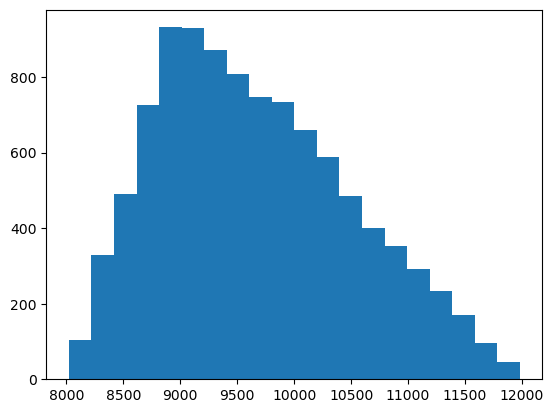

In [141]:
a = [8000, 9000, 12000]
sales = np.random.triangular(a[0], a[1], a[2], size=10000)
plt.hist(sales, bins=20)
plt.show()

# Product Variables Ranges

Now let's define the variables that describe our product. Some are hard-coded, other have ranges, and some are dependent on others.

In [39]:
# Product Variables Ranges (user input)
class ProductVariablesRanges:
    def __init__(self,
                 years_before_development = 1.5,
                 years_of_development_growth = 0,
                 years_of_development_maturity = [3, 4, 5],
                 years_of_development_decline = 0,
                 years_before_sales = 0,
                 years_of_sales_growth = 0,
                 years_of_sales_maturity = [8, 10, 12],
                 years_of_sales_decline = 0,
                 development_ftes = [4, 5, 6],
                 maintenance_ftes = [0, 0.5, 1],
                 unit_cost_pv=[8000, 9000, 12000],
                 unit_price_cost_factor = [1.9, 2.0, 2.1],
                 yearly_unit_sales_lowest_price = [110, 120, 150],
                 yearly_unit_sales_highest_price = [80, 90, 120]):
        
        # development years profile
        self.years_before_development = years_before_development
        self.years_of_development_growth = years_of_development_growth
        self.years_of_development_maturity = years_of_development_maturity
        self.years_of_development_decline = years_of_development_decline

        # sales years profile
        self.years_before_sales = years_before_sales
        self.years_of_sales_growth = years_of_sales_growth
        self.years_of_sales_maturity = years_of_sales_maturity
        self.years_of_sales_decline = years_of_sales_decline
        
        # the number of people (full time equivalents) on the development team
        self.development_ftes = development_ftes

        # the number of people that need to keep working on the product after development
        self.maintenance_ftes = maintenance_ftes
        
        # the cost to manufacture one unit of the product (in present dollars)
        self.unit_cost_pv = unit_cost_pv
        
        # the selling price cost factors to compute the price of the product (in present dollars)
        self.unit_price_cost_factor = unit_price_cost_factor

        # the number of units that are expected to be sold per year
        self.yearly_unit_sales_lowest_price = yearly_unit_sales_lowest_price
        self.yearly_unit_sales_highest_price = yearly_unit_sales_highest_price

    def lowest_price(self):
        return self.unit_cost_pv[0] * self.unit_price_cost_factor[0]
    
    def highest_price(self):
        return self.unit_cost_pv[2] * self.unit_price_cost_factor[2]

product_variables_ranges = ProductVariablesRanges()

This is how we can view the range of unit cost.

In [40]:
product_variables_ranges.unit_cost_pv

[8000, 9000, 12000]

# Triangle

Here is the triangle random number generator. It takes a flag ("expected") indicating whether or not it should simply return the expected value.

In [51]:
# Return a single random number, given a low, expected, and high range, using a triangular distribution
# Just return the expected number if requested, or if the range is invalid
def triangle(a, just_expected = False):

    # if a is a single number, return it
    if isinstance(a, (int, float)):
        return a

    # if the range is invalid, return the likely (middle) value
    if(a[0] > a[1] or a[1] > a[2] or a[0] >= a[2]):
        return a[1]
    
    # if requested, just return the likely (middle) value
    if (just_expected):
        return a[1]
    
    # return a random number, given a low, likely, and high range, using a triangular distribution
    return np.random.triangular(a[0], a[1], a[2])

This is how we can use the triangle function to generate a random number for unit cost, or just the expected cost. Feel free to run this cell multiple times.

In [78]:
print(triangle(product_variables_ranges.unit_cost_pv))
print(triangle(product_variables_ranges.unit_cost_pv, True))

8959.260379733585
9000


# Tornado Chart

A tornado chart is a chart that shows the range of NPV due to a single product variable. It is a stacked horizontal bar chart with the variable that creates the most variance of NPV at the top, and the least at the bottom. To create a tornado chart, we need the random number generator to vary just one product variable at a time (and use the expected value for all the rest). Here are the variables for which we want to compute a range and then place in our tornado chart.

In [79]:
from enum import Enum

# Used to lock in all but one variable when computing a tornado sensitivity analysis
class Tornado(Enum):
    OFF = 0
    Dev_Ftes = 1
    Dev_Years = 2
    Maint_Ftes = 3
    Sales_Years = 4
    Unit_Cost = 5
    Margin = 6
    Yearly_Sales = 7

# Product Variables Snapshot

This creates a snapshot of all the product variables, given their ranges.

If a tornado sensitivity analysis is being computed, then limit the randomness of variables to just the one specified.

Notice that unit_price_pv is not independatly random, but rather depends on unit_cost_pv and the unit_price_cost_factor. Also, the yearly_unit_sales is a function of price and an interpolation of the two extreeme estimates of yearly_unit_sales_lowest_price and yearly_unit_sales_highest_price.

In [110]:
# Create a snapshot of the product variables with random values
class ProductVariablesSnapshot:
    def __init__(self, product_variables_ranges, tornado = Tornado.OFF):
        
        # convert various ranges to actual values using a triangular distribution (or use the likely value if a tornado sensitivity analysis is being performed)
        self.development_ftes = triangle(product_variables_ranges.development_ftes, tornado != Tornado.OFF and tornado != Tornado.Dev_Ftes)
        self.years_before_development = triangle(product_variables_ranges.years_before_development)
        self.years_of_development_growth = triangle(product_variables_ranges.years_of_development_growth)
        self.years_of_development_maturity = triangle(product_variables_ranges.years_of_development_maturity, tornado != Tornado.OFF and tornado != Tornado.Dev_Years)
        self.years_of_development_decline = triangle(product_variables_ranges.years_of_development_decline)
        self.maintenance_ftes = triangle(product_variables_ranges.maintenance_ftes, tornado != Tornado.OFF and tornado != Tornado.Maint_Ftes)
        self.years_before_sales = triangle(product_variables_ranges.years_before_sales)
        self.years_of_sales_growth = triangle(product_variables_ranges.years_of_sales_growth)
        self.years_of_sales_maturity = triangle(product_variables_ranges.years_of_sales_maturity, tornado != Tornado.OFF and tornado != Tornado.Sales_Years)
        self.years_of_sales_decline = triangle(product_variables_ranges.years_of_sales_decline)
        self.unit_cost_pv = triangle(product_variables_ranges.unit_cost_pv, tornado != Tornado.OFF and tornado != Tornado.Unit_Cost)
        self.unit_price_cost_factor = triangle(product_variables_ranges.unit_price_cost_factor, tornado != Tornado.OFF and tornado != Tornado.Margin)

        # some product variables are dependent on others, so we need to compute them

        # compute the unit price
        self.unit_price_pv = self.unit_cost_pv * self.unit_price_cost_factor

        # interpolate the yearly unit sales range as a function of the unit price
        price_range = np.array([product_variables_ranges.lowest_price(), product_variables_ranges.highest_price()])
        yearly_unit_sales_range = [0, 0, 0]
        for i in range(3):
            sales_range_i = np.array([product_variables_ranges.yearly_unit_sales_lowest_price[i], product_variables_ranges.yearly_unit_sales_highest_price[i]])
            yearly_unit_sales_range[i] = np.interp(self.unit_price_pv, price_range, sales_range_i)
        
        # convert the sales range to an actual value using a triangular distribution
        self.yearly_unit_sales = triangle(yearly_unit_sales_range, tornado != Tornado.OFF and tornado != Tornado.Yearly_Sales)

        # precalculate the total remaining years
        self.total_remaining_years = self.years_before_development + self.years_of_development_growth + self.years_of_development_maturity + self.years_of_development_decline + self.years_before_sales + self.years_of_sales_growth + self.years_of_sales_maturity + self.years_of_sales_decline

    # compute the development full time equivalents for a given month
    def development_ftes_this_month(self, month):
        if month < self.years_before_development * 12:
            return 0
        month -= self.years_before_development * 12
        if month < self.years_of_development_growth * 12:
            return self.development_ftes * month / (self.years_of_development_growth * 12)
        month -= self.years_of_development_growth * 12
        if month < self.years_of_development_maturity * 12:
            return self.development_ftes
        month -= self.years_of_development_maturity * 12
        if month < self.years_of_development_decline * 12:
            return self.development_ftes * (1 - month / (self.years_of_development_decline * 12))
        return self.maintenance_ftes
    
    # compute the unit sales for a given month
    def unit_sales_this_month(self, month):
        month -= self.years_before_development * 12
        month -= self.years_of_development_growth * 12
        month -= self.years_of_development_maturity * 12
        month -= self.years_of_development_decline * 12
        if month < self.years_before_sales * 12:
            return 0
        month -= self.years_before_sales * 12
        if month < self.years_of_sales_growth * 12:
            return self.yearly_unit_sales * month / (self.years_of_sales_growth * 12) / 12
        month -= self.years_of_sales_growth * 12
        if month < self.years_of_sales_maturity * 12:
            return self.yearly_unit_sales / 12
        month -= self.years_of_sales_maturity * 12
        if month < self.years_of_sales_decline * 12:
            return self.yearly_unit_sales * (1 - month / (self.years_of_sales_decline * 12)) / 12
        return 0
    
    def __str__(self):
        return (f"development_ftes={self.development_ftes},\n"
            f"years_before_development={self.years_before_development},\n"
            f"years_of_development_growth={self.years_of_development_growth},\n"
            f"years_of_development_maturity={self.years_of_development_maturity},\n"
            f"years_of_development_decline={self.years_of_development_decline},\n"
            f"maintenance_ftes={self.maintenance_ftes},\n"
            f"years_before_sales={self.years_before_sales},\n"
            f"years_of_sales_growth={self.years_of_sales_growth},\n"
            f"years_of_sales_maturity={self.years_of_sales_maturity},\n"
            f"years_of_sales_decline={self.years_of_sales_decline},\n"
            f"unit_cost_pv={self.unit_cost_pv},\n"
            f"unit_price_cost_factor={self.unit_price_cost_factor},\n"
            f"unit_price_pv={self.unit_price_pv},\n"
            f"yearly_unit_sales={self.yearly_unit_sales},\n"
            f"total_remaining_years={self.total_remaining_years}")

Here is what the snapshot of product variable looks like, allowing all ranges to be computed with the random number generator. You can execute the cell below multiple times to see various scenarios.

In [111]:
print(ProductVariablesSnapshot(product_variables_ranges))

development_ftes=5.301538218163849,
years_before_development=1.5,
years_of_development_growth=0,
years_of_development_maturity=4.515323483383113,
years_of_development_decline=0,
maintenance_ftes=0.4321474214309827,
years_before_sales=0,
years_of_sales_growth=0,
years_of_sales_maturity=10.989603678414642,
years_of_sales_decline=0,
unit_cost_pv=8141.3174054209185,
unit_price_cost_factor=1.9286022142068107,
unit_price_pv=15701.36277465523,
yearly_unit_sales=129.30805949917288,
total_remaining_years=17.004927161797756


Here is what the snapshot of product variable looks like, allowing only Yearly_Sales to change.  You can execute the cell below multiple times to see various scenarios.

In [120]:
product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges, Tornado.Yearly_Sales)
print(product_variables_snapshot)

development_ftes=5,
years_before_development=1.5,
years_of_development_growth=0,
years_of_development_maturity=4,
years_of_development_decline=0,
maintenance_ftes=0.5,
years_before_sales=0,
years_of_sales_growth=0,
years_of_sales_maturity=10,
years_of_sales_decline=0,
unit_cost_pv=9000,
unit_price_cost_factor=2.0,
unit_price_pv=18000.0,
yearly_unit_sales=122.14259996474722,
total_remaining_years=15.5


# NPV

Given the company_constants and the product_variable_snapshot, we can compute the NPV. We do this by calculating sales, cost_of_goods, sga, and development_costs. This is what the NPV calculator will return.

In [107]:
# The result of a single NPV calculation
class NpvCalculationResult:
    def __init__(self):
        self.development_cost = 0
        self.sales = 0
        self.cost_of_goods = 0
        self.sga = 0
        self.unit_sales = 0
        self.total_remaining_years = 0

    def npv(self):
        return self.sales - self.cost_of_goods - self.sga - self.development_cost

    def roi(self):
        return self.npv() / self.development_cost

    def annualized_roi(self, years):
        return (1 + self.roi()) ** (1 / years) - 1
    
    def __str__(self):
        return (f"development_cost={self.development_cost},\n"
            f"sales={self.sales},\n"
            f"cost_of_goods={self.cost_of_goods},\n"
            f"sga={self.sga},\n"
            f"unit_sales={self.unit_sales},\n"
            f"total_remaining_years={self.total_remaining_years},\n"
            f"npv={self.npv()},\n"
            f"roi={self.roi()}")

This is the actual calculation code. Notice it breaks down the problem by iterating through each month of the project lifetime.

In [121]:
# Calculate the NPV of a product
def calculate_npv(product_variables_snapshot, company_constants):

    # this is what we will calculate and return 
    result = NpvCalculationResult()

    # loop through all the months
    for month in range(round(product_variables_snapshot.years_before_development * 12), round(product_variables_snapshot.total_remaining_years * 12)):
    
        # compute the development_ftes for this month
        development_ftes = product_variables_snapshot.development_ftes_this_month(month)

        # compute the unit sales for this month
        unit_sales = product_variables_snapshot.unit_sales_this_month(month)

        # compute the future value of the cost of development, unit cost, and unit price for this month
        monthly_development_cost_fte_fv = fv(company_constants.yearly_development_fte_cost_pv / 12, company_constants.inflation / 12, month)
        unit_cost_fv = fv(product_variables_snapshot.unit_cost_pv, company_constants.inflation / 12, month)
        unit_price_fv = fv(product_variables_snapshot.unit_price_pv, company_constants.inflation / 12, month)

        # compute the selling, general, and administrative expenses per unit
        sga_fv = unit_price_fv * company_constants.sga_percentage

        # add the cost of development in present value terms
        result.development_cost += pv(development_ftes * monthly_development_cost_fte_fv, company_constants.market_return / 12, month)
        result.unit_sales += unit_sales
        result.sales += pv(unit_sales * unit_price_fv, company_constants.market_return / 12, month)
        result.cost_of_goods += pv(unit_sales * unit_cost_fv, company_constants.market_return / 12, month)
        result.sga += pv(unit_sales * sga_fv, company_constants.market_return / 12, month)

    # handy for the result
    result.total_remaining_years = product_variables_snapshot.total_remaining_years

    return result

Let's compute the NPV for our variables.

In [131]:
result = calculate_npv(product_variables_snapshot, company_constants)
print(result)

development_cost=1249999.9999999942,
sales=21985667.993654564,
cost_of_goods=10992833.996827282,
sga=6595700.3980963435,
unit_sales=1221.425999647472,
total_remaining_years=15.5,
npv=3147133.598730944,
roi=2.517706878984767,


Let's compute npv for several scenarios.

In [138]:
for _ in range(5):
    product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges)
    result = calculate_npv(product_variables_snapshot, company_constants)
    print(result.npv())

3967435.0461897617
3285446.5249823756
2522336.011771735
4600282.695204292
2825955.089266235


Here is a place we can store some stats of each scenario.

In [139]:
# Track all the results of multiple calculations
class SimulationTracker:
    def __init__(self):
        self.npvs_millions = []
        self.development_costs_millions = []
        self.annualized_rois_percentage = []
        self.unit_sales_thousands = []
        self.sales_millions = []
        self.years = []
    
    def add(self, result):
        self.npvs_millions.append(result.npv() / 1000000)
        self.development_costs_millions.append(result.development_cost / 1000000)
        self.annualized_rois_percentage.append(result.annualized_roi(result.total_remaining_years) * 100)
        self.unit_sales_thousands.append(result.unit_sales / 1000)
        self.sales_millions.append(result.sales / 1000000)
        self.years.append(result.total_remaining_years)

Now let's keep stats of 1000 simulations.

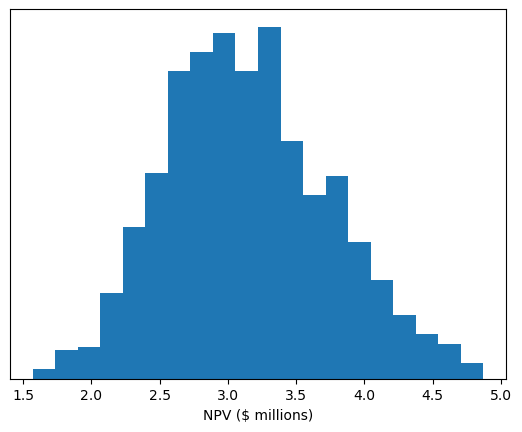

In [144]:
simulation_tracker = SimulationTracker()

for _ in range(1000):
    product_variables_snapshot = ProductVariablesSnapshot(product_variables_ranges)
    result = calculate_npv(product_variables_snapshot, company_constants)
    simulation_tracker.add(result)

plt.hist(simulation_tracker.npvs_millions, bins=20)
plt.xlabel('NPV ($ millions)', fontsize=10)
plt.yticks([])
plt.show()

# Putting it all together

Now let's get ready to put it all together. But first we need a place to store tornado simulations.

In [145]:
class TornadoTracker:
    def __init__(self, tornado, name):
        self.tornado = tornado
        self.name = name
        self.min_value = float('inf')
        self.max_value = float('-inf')

    def add(self, value):
        if value < self.min_value:
            self.min_value = value
        if value > self.max_value:
            self.max_value = value
    
    def range(self):
        return self.max_value - self.min_value

Here is the final analysis code:

In [148]:
class MonteCarloAnalyzer:
    def __init__(self, company_constants, product_variables_ranges):
        self.company_constants = company_constants
        self.product_variables_ranges = product_variables_ranges
        self.simulation_tracker = SimulationTracker()
        self.tornado_trackers = []
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Ftes, 'Dev FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Dev_Years, 'Dev Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Maint_Ftes, 'Maint FTEs'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Sales_Years, 'Sales Years'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Unit_Cost, 'Unit Cost'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Margin, 'Margin'))
        self.tornado_trackers.append(TornadoTracker(Tornado.Yearly_Sales, 'Yearly Sales'))

    def analyze(self):
        # compute the monte carlo analysis
        for i in range(2000):
            product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges)
            result = calculate_npv(product_variables_snapshot, self.company_constants)
            self.simulation_tracker.add(result)

        # compute the tornado analysis
        for i in range(100):    
            for tornado_tracker in self.tornado_trackers:
                product_variables_snapshot = ProductVariablesSnapshot(self.product_variables_ranges, tornado_tracker.tornado)
                result = calculate_npv(product_variables_snapshot, self.company_constants)
                tornado_tracker.add(result.npv() / 1000000)

        # Sort the tornado trackers by range
        self.tornado_trackers.sort(key=lambda x: x.range())
    
    # create a histogram
    def create_histogram(self, data, bins, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.hist(data, bins=bins, edgecolor='black')
        plt.yticks([])
        plt.xlabel(xlabel, fontsize=10)

    # create a tornado plot
    def create_tornado_plot(self, names, ranges, min_values, xlabel, subplot_position, rows, cols):
        plt.subplot(rows, cols, subplot_position)
        plt.barh(names, ranges, left=min_values)
        plt.xlabel(xlabel)

    # plot the results
    def plot(self, file_path = ""):
        rows = 2
        cols = 3
        plt.figure(figsize=(10, 5))

        self.create_histogram(self.simulation_tracker.unit_sales_thousands, 30, 'Sales (units/1000)', 1, rows, cols)
        self.create_histogram(self.simulation_tracker.sales_millions, 30, 'Sales ($ millions)', 2, rows, cols)
        self.create_histogram(self.simulation_tracker.development_costs_millions, 30, 'Development ($ millions)', 3, rows, cols)
        self.create_histogram(self.simulation_tracker.npvs_millions, 30, 'NPV ($ millions)', 4, rows, cols)
        self.create_histogram(self.simulation_tracker.annualized_rois_percentage, 30, 'Annualized ROI (%)', 5, rows, cols)
        # self.create_histogram(self.years, 30, 'Product Years', 6, rows, cols)

        tornado_names = [tornado_tracker.name for tornado_tracker in self.tornado_trackers]
        tornado_ranges = [tornado_tracker.range() for tornado_tracker in self.tornado_trackers]
        tornado_min_values = [tornado_tracker.min_value for tornado_tracker in self.tornado_trackers]
        self.create_tornado_plot(tornado_names, tornado_ranges, tornado_min_values, 'NPV Sensitivity ($ millions)', 6, rows, cols)

        plt.tight_layout()
        if( file_path != ""):
            plt.savefig(file_path)
        else:
            plt.show()
        plt.close()


Let's run it!

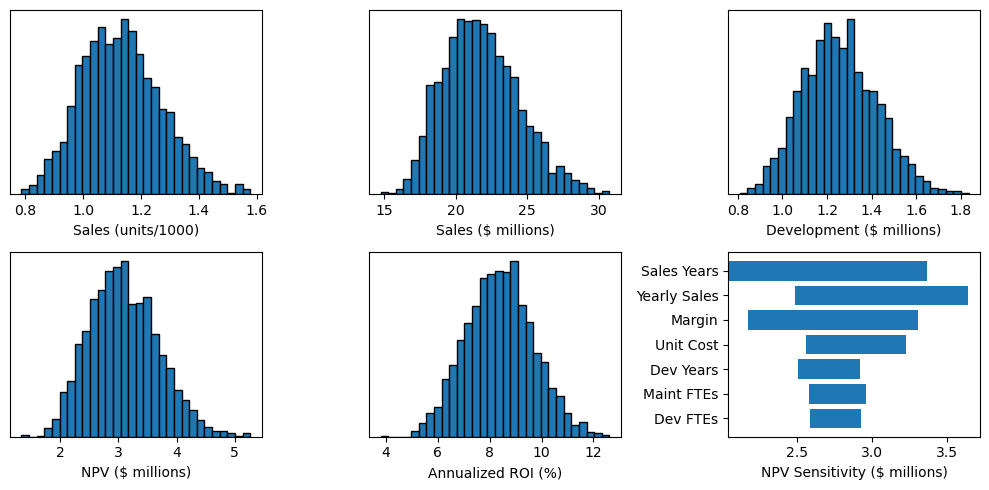

In [149]:
monte_carlo = MonteCarloAnalyzer(company_constants, product_variables_ranges)
monte_carlo.analyze()
monte_carlo.plot()